<a href="https://colab.research.google.com/github/ITACHI812/flower-project---/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Paths
TRAIN_ZIP_PATH = "/content/drive/MyDrive/train_dir.zip"
TEST_ZIP_PATH = "/content/drive/MyDrive/test_dir.zip"
EXTRACT_PATH = "/content/flower_dataset"
MODEL_PATH = "/content/drive/MyDrive/flower_classifier.keras"
CLASS_INDICES_PATH = "/content/drive/MyDrive/class_indices.json"


In [ ]:
# Extract only once
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH, exist_ok=True)
    with zipfile.ZipFile(TRAIN_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    with zipfile.ZipFile(TEST_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
print("✅ Dataset extracted successfully!")


✅ Dataset extracted successfully!


In [ ]:
# Data Generators with Rescaling
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

train_generator = datagen.flow_from_directory(
    os.path.join(EXTRACT_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    os.path.join(EXTRACT_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test Data Generator (Unlabeled)
test_path = os.path.join(EXTRACT_PATH, "test")
test_image_paths = glob.glob(os.path.join(test_path, '*.*'))  # All test images

print(f"✅ Train images: {train_generator.samples}")
print(f"✅ Validation images: {val_generator.samples}")
print(f"✅ Test images loaded for prediction: {len(test_image_paths)}")


Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.
✅ Train images: 2198
✅ Validation images: 548
✅ Test images loaded for prediction: 924


In [ ]:
import os

# Verify extraction path
EXTRACT_PATH = "/content/flower_dataset"
print("📂 Extracted files:", os.listdir(EXTRACT_PATH))

# Verify train and test folders
print("📂 Train folder contents:", os.listdir(os.path.join(EXTRACT_PATH, 'train')))
print("📂 Test folder contents:", os.listdir(os.path.join(EXTRACT_PATH, 'test')))


📂 Extracted files: ['train', 'test']
📂 Train folder contents: ['rose', 'tulip', 'dandelion', 'daisy', 'sunflower']
📂 Test folder contents: ['Image_489.jpg', 'Image_273.jpg', 'Image_715.jpg', 'Image_234.jpg', 'Image_59.jpg', 'Image_841.jpg', 'Image_335.jpg', 'Image_116.jpg', 'Image_113.jpg', 'Image_910.jpg', 'Image_258.jpg', 'Image_699.jpg', 'Image_496.jpg', 'Image_197.jpg', 'Image_569.jpg', 'Image_570.jpg', 'Image_351.jpg', 'Image_75.jpg', 'Image_316.jpg', 'Image_171.jpg', 'Image_893.jpg', 'Image_651.jpg', 'Image_695.jpg', 'Image_906.jpg', 'Image_845.jpg', 'Image_672.jpg', 'Image_378.jpg', 'Image_6.jpg', 'Image_294.jpg', 'Image_832.jpg', 'Image_666.jpg', 'Image_565.jpg', 'Image_519.jpg', 'Image_870.jpg', 'Image_431.jpg', 'Image_244.jpg', 'Image_828.jpg', 'Image_88.jpg', 'Image_735.jpg', 'Image_453.jpg', 'Image_767.jpg', 'Image_801.jpg', 'Image_145.jpg', 'Image_515.jpg', 'Image_674.jpg', 'Image_157.jpg', 'Image_797.jpg', 'Image_752.jpg', 'Image_531.jpg', 'Image_268.jpg', 'Image_892.jpg'

In [ ]:
print(f"Train Samples: {train_generator.samples}")
print(f"Validation Samples: {val_generator.samples}")
print(f"Test Images: {len(test_image_paths)}")


Train Samples: 2198
Validation Samples: 548
Test Images: 924


In [ ]:
import sys

def train_model():
    print("🟡 Initializing VGG16 model...")
    sys.stdout.flush()  # Ensure output appears in Colab

    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    print("✅ VGG16 model loaded successfully.")
    sys.stdout.flush()

    vgg_base.trainable = False  # Freeze VGG16 layers

    model = Sequential([
        vgg_base,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    print("✅ Model architecture created.")
    sys.stdout.flush()

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    print("✅ Model compiled successfully.")
    sys.stdout.flush()

    # Confirm dataset details
    print(f"🔄 Training samples: {train_generator.samples}")
    print(f"🔄 Validation samples: {val_generator.samples}")
    sys.stdout.flush()

    print("🔄 Starting model training...")
    sys.stdout.flush()

    history = model.fit(train_generator, validation_data=val_generator, epochs=15, verbose=1)

    model.save(MODEL_PATH)
    print(f"✅ Model saved successfully at {MODEL_PATH}")
    sys.stdout.flush()

    return model, history

# Explicitly call train_model to ensure it's executed
model, history = train_model()


🟡 Initializing VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ VGG16 model loaded successfully.
✅ Model architecture created.
✅ Model compiled successfully.
🔄 Training samples: 2198
🔄 Validation samples: 548
🔄 Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1086s 16s/step - accuracy: 0.4515 - loss: 1.3860 - val_accuracy: 0.7318 - val_loss: 0.7893
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1117s 16s/step - accuracy: 0.7608 - loss: 0.6677 - val_accuracy: 0.7719 - val_loss: 0.6515
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1117s 16s/step - accuracy: 0.8235 - loss: 0.4935 - val_accuracy: 0.7920 - val_loss: 0.6420
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1129s 16s/step - accuracy: 0.8714 - loss: 0.3899 - val_accuracy: 0.7719 - val_loss: 0.6120
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1125s 16s/step - accuracy: 0.9118 - loss: 0.2972 - val_accuracy: 0.8084 - val_loss: 0.5710
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1138s 17s/step - accuracy: 0.9396 - loss: 0.2422 - val_accuracy: 0.8175 - val_loss: 0.5383
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1125s 16s/step - accuracy: 0.9470 - loss: 0.1971 - val_accuracy: 0.8120 - val_loss: 0.5373
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 1144s 17s/step - accuracy: 0.9709 - loss: 0.1568 - val_accu

In [ ]:
if os.path.exists(MODEL_PATH):
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully!")
else:
    model, history = train_model()


✅ Model loaded successfully!


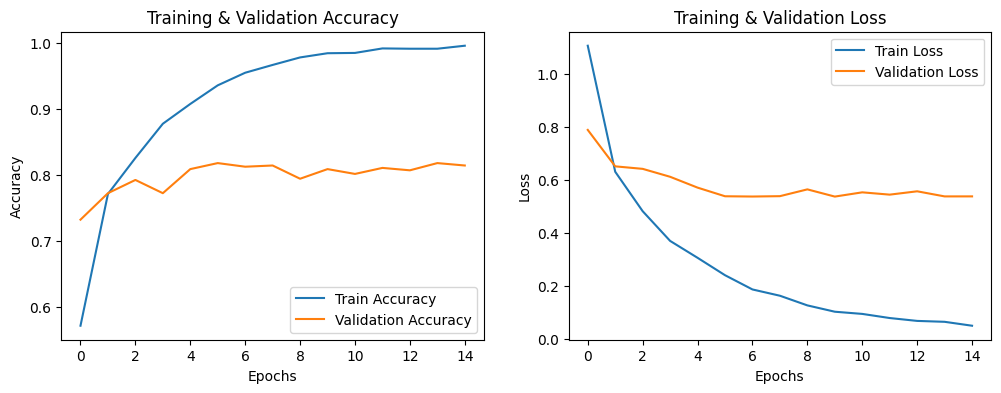

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy Graph
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    # Loss Graph
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    plt.show()

plot_training_history(history)


In [ ]:
accuracy = history.history['accuracy'][-1] * 100
print(f"Final Training Accuracy: {accuracy:.2f}%")


Final Training Accuracy: 99.55%


In [ ]:
# Evaluate on Validation Data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 216s 12s/step - accuracy: 0.8122 - loss: 0.5390
✅ Final Validation Accuracy: 81.39%


In [ ]:
with open(CLASS_INDICES_PATH, "r") as f:
    class_names = json.load(f)
print(class_names)


{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [ ]:
# Save Class Indices (Overwrite to ensure correctness)
with open(CLASS_INDICES_PATH, "w") as f:
    json.dump(train_generator.class_indices, f)
print("✅ Class indices saved successfully.")


✅ Class indices saved successfully.


In [ ]:
with open(CLASS_INDICES_PATH, "r") as f:
    class_names = json.load(f)
print("✅ Class Indices:", class_names)


✅ Class Indices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [ ]:
import json

with open(CLASS_INDICES_PATH, "r") as f:
    class_names = json.load(f)

print("✅ Class Indices Loaded Successfully:")
print(class_names)


✅ Class Indices Loaded Successfully:
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


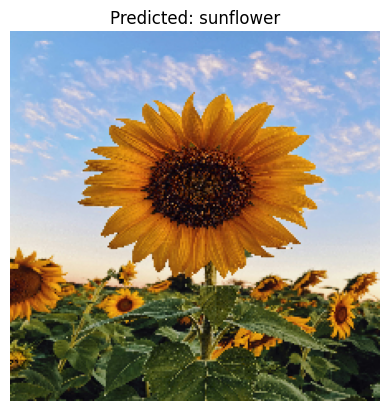

Predicted Flower: sunflower


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import json

def predict_flower(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    with open(CLASS_INDICES_PATH, "r") as f:
        class_names = json.load(f)

    # Invert class indices to match predicted index
    inverted_class_names = {v: k for k, v in class_names.items()}
    predicted_index = np.argmax(prediction)
    predicted_class = inverted_class_names.get(predicted_index, "Unknown")

    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class

image_path = "/content/drive/MyDrive/image1.jpg"
result = predict_flower(image_path)
print("Predicted Flower:", result)


In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize Model Architecture
plot_model(model, to_file='/content/drive/MyDrive/model_architecture.png',
           show_shapes=True, show_layer_names=True)

print("✅ Model architecture saved as 'model_architecture.png' in your Drive.")


✅ Model architecture saved as 'model_architecture.png' in your Drive.


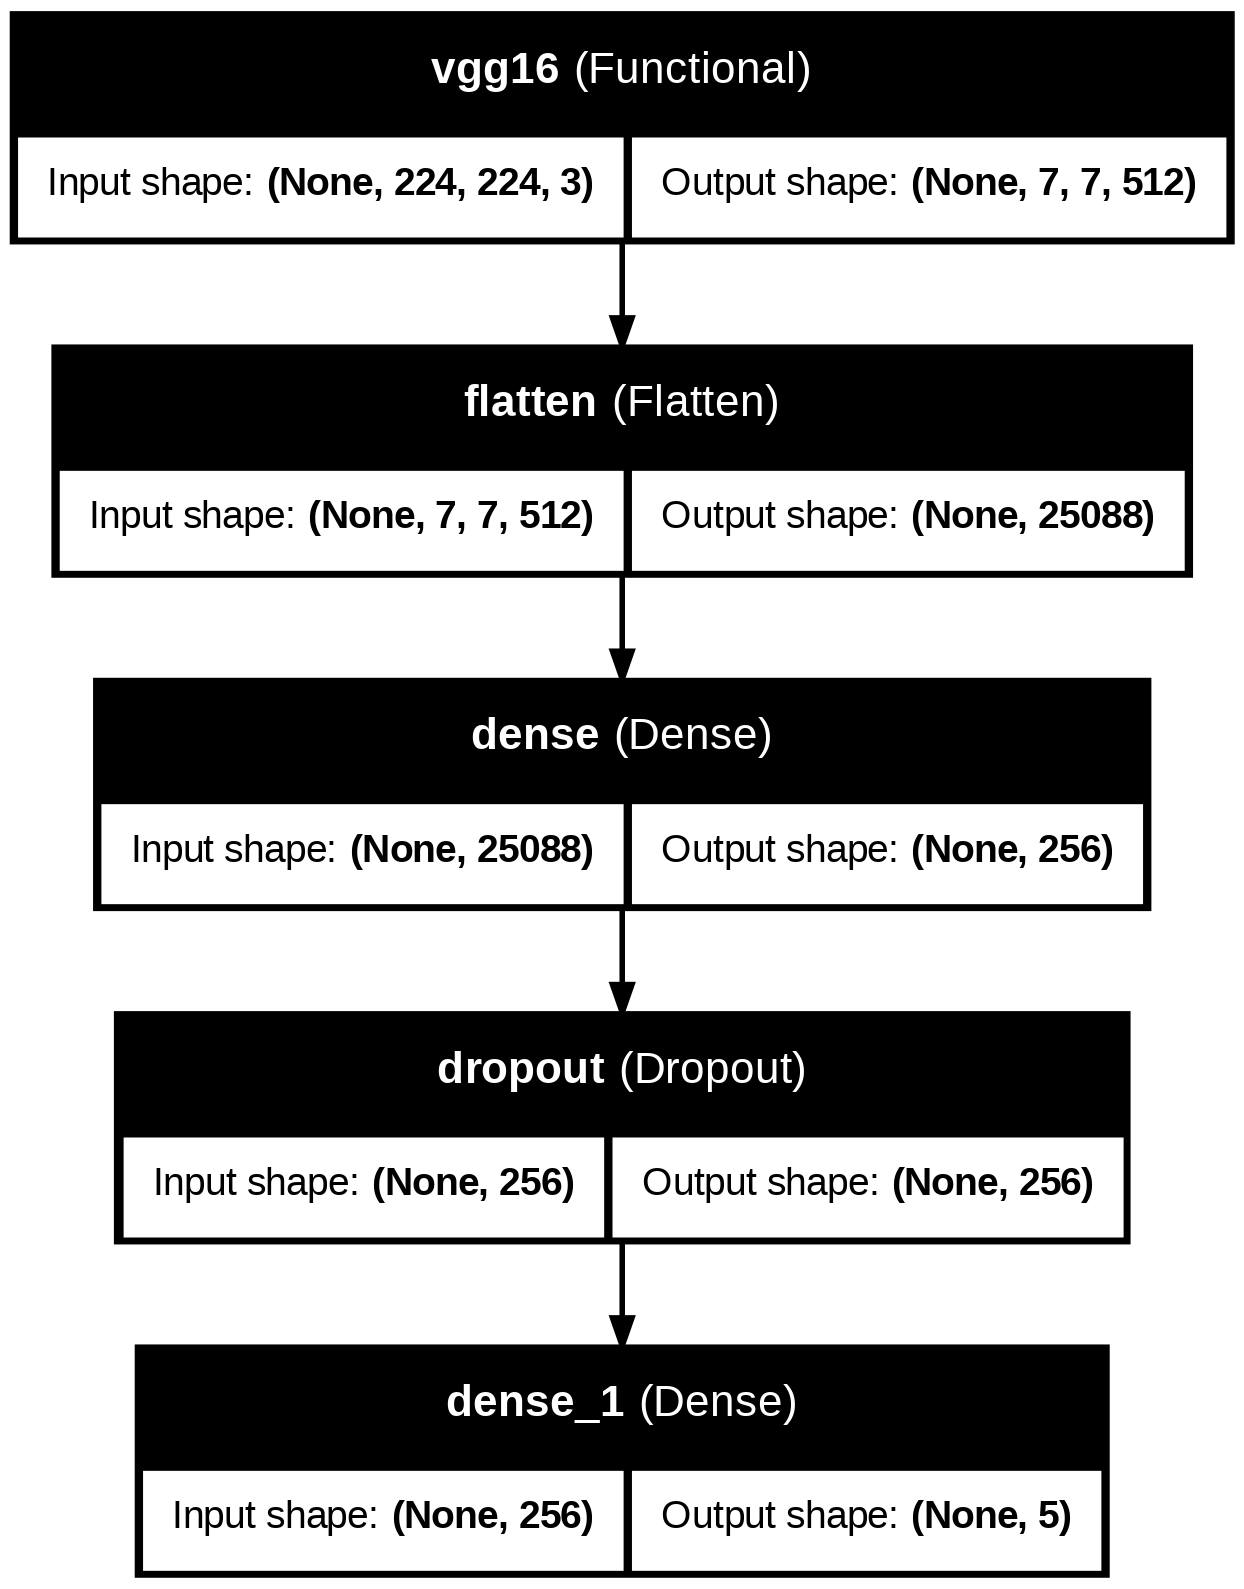

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.utils import plot_model

# Save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved image directly in the output
display(Image('model_architecture.png'))


In [ ]:
import os

drive_path = '/content/drive/MyDrive/'
print("Contents in MyDrive:", os.listdir(drive_path))

# Check inside the suspected test folder path
test_path = os.path.join(drive_path, 'test_dir')
if os.path.exists(test_path):
    print("✅ Test directory found.")
    print("Contents in Test Folder:", os.listdir(test_path))
else:
    print("❌ Test directory NOT found. Verify the folder name or location.")


Contents in MyDrive: ['Colab Notebooks', 'train_dir.zip', '.ipynb_checkpoints', 'test_dir.zip', 'class_indices.json', 'flower_classifier.keras', 'image 7.jpg', 'image3.jpg', 'image1.jpg', 'test_predictions.txt', 'model_architecture.png']
❌ Test directory NOT found. Verify the folder name or location.


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/test_dir.zip'
extract_path = '/content/test_data'

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Test data extracted successfully.")


✅ Test data extracted successfully.


In [ ]:
import glob

test_image_paths = glob.glob(os.path.join(extract_path, '*/*.[jp][pn]g'))

print(f"✅ Loaded {len(test_image_paths)} test images for evaluation.")


✅ Loaded 924 test images for evaluation.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def load_test_images(image_paths):
    test_images = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        test_images.append(img_array)
    return np.array(test_images)

test_images = load_test_images(test_image_paths)
print(f"✅ Test images prepared: {test_images.shape}")


✅ Test images prepared: (924, 224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


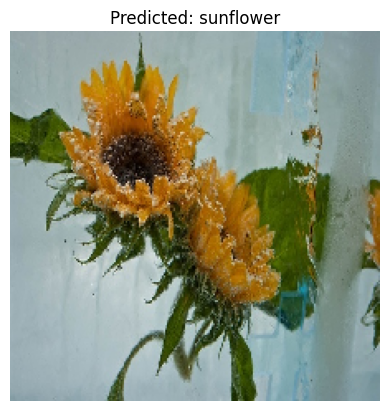

Predicted Flower: sunflower


In [ ]:
def predict_flower(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class

# Example Usage
image_path = test_image_paths[0]  # Test with any image from the list
result = predict_flower(image_path)
print("Predicted Flower:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


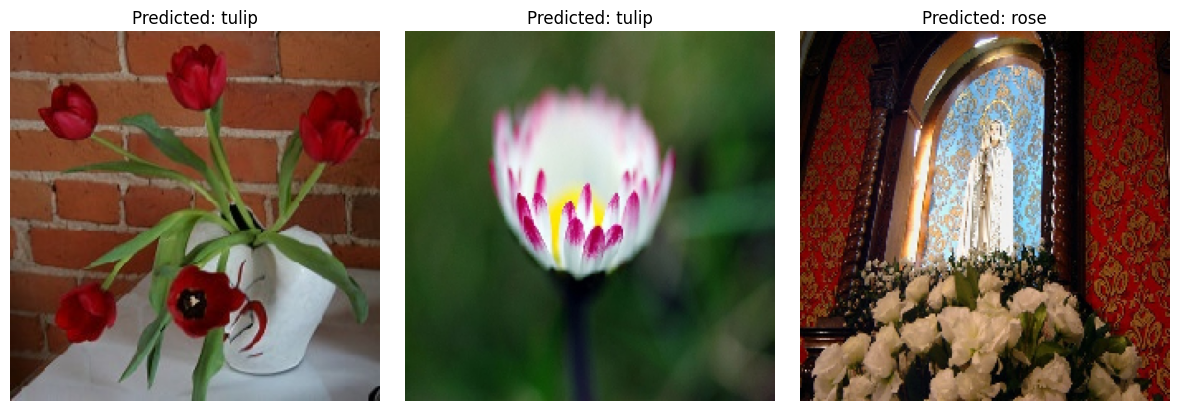

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_multiple_images(image_paths, num_images=6):
    selected_images = random.sample(image_paths, num_images)  # Randomly pick 5-6 images

    plt.figure(figsize=(12, 8))

    for i, img_path in enumerate(selected_images):
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)

        class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
        predicted_class = class_names[np.argmax(prediction)]

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class}")

    plt.tight_layout()
    plt.show()

# Example Usage
predict_multiple_images(test_image_paths, num_images=3)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
import json

# Load the trained model
MODEL_PATH = "/content/drive/MyDrive/flower_classifier.keras"
CLASS_INDICES_PATH = "/content/drive/MyDrive/class_indices.json"

model = load_model(MODEL_PATH)
print(" Model loaded successfully!")

# Load class indices
with open(CLASS_INDICES_PATH, "r") as f:
    class_names = json.load(f)
print(" Class indices loaded successfully!")

 Model loaded successfully!
 Class indices loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


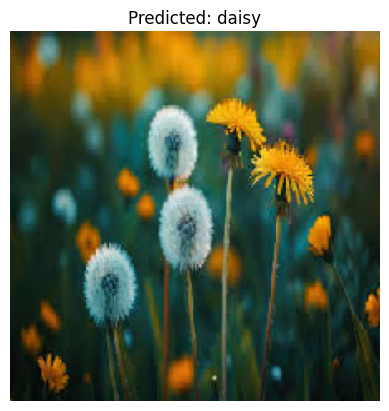

Predicted Flower: daisy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_flower(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    # Invert class indices to match predicted index
    inverted_class_names = {v: k for k, v in class_names.items()}
    predicted_index = np.argmax(prediction)
    predicted_class = inverted_class_names.get(predicted_index, "Unknown")

    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class

# Example Prediction
image_path = "/content/drive/MyDrive/image13.jpg"  # Change path for new images
result = predict_flower(image_path)
print("Predicted Flower:", result)